In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import random


# Data download and preprocessing. Creat samples


In [2]:
# the start and end date
start_date = dt.datetime(2020, 4, 1)
end_date = dt.datetime(2023, 4, 1)

# loading data from yahoo finance
data = yf.download("GOOGL", start_date, end_date)

# Set the maximum number of col and rows to display
pd.set_option('display.max_rows', 4)
pd.set_option('display.max_columns', 5)
print(data)

[*********************100%***********************]  1 of 1 completed

Price                       Adj Close       Close  ...        Open    Volume
Ticker                          GOOGL       GOOGL  ...       GOOGL     GOOGL
Date                                               ...                      
2020-04-01 00:00:00+00:00   54.968887   55.105000  ...   56.200001  51970000
2020-04-02 00:00:00+00:00   55.713547   55.851501  ...   55.000000  56410000
...                               ...         ...  ...         ...       ...
2023-03-30 00:00:00+00:00  100.640800  100.889999  ...  100.910004  33086200
2023-03-31 00:00:00+00:00  103.473785  103.730003  ...  101.300003  36863400

[756 rows x 6 columns]


In [3]:
# Let's split the data set into test and training samples

# training samples : testing samples = 20 : 80 

train_split = 0.8
num_of_train_samples = round(len(data) * train_split)  
num_of_test_split = len(data) - num_of_train_samples
print(num_of_train_samples, num_of_test_split, len(data) == num_of_train_samples + num_of_test_split)

605 151 True


In [4]:
# splitting the dataset
train_data = data.iloc[:num_of_train_samples]
test_data = data.iloc[num_of_train_samples:]
print(train_data)

Price                       Adj Close       Close  ...        Open    Volume
Ticker                          GOOGL       GOOGL  ...       GOOGL     GOOGL
Date                                               ...                      
2020-04-01 00:00:00+00:00   54.968887   55.105000  ...   56.200001  51970000
2020-04-02 00:00:00+00:00   55.713547   55.851501  ...   55.000000  56410000
...                               ...         ...  ...         ...       ...
2022-08-23 00:00:00+00:00  113.578758  113.860001  ...  113.480003  15870400
2022-08-24 00:00:00+00:00  113.409187  113.690002  ...  113.500000  17734600

[605 rows x 6 columns]


In [5]:
train_data.shape

(605, 6)

In [9]:
# Select Open Price values
dataset_test = test_data.Open.values
dataset_train = train_data.Open.values
print(dataset_train.shape, dataset_test.shape)

(605, 1) (151, 1)


In [10]:
# Normalize the data to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# scaling dataset
scaled_test = scaler.fit_transform(dataset_test)
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5], scaled_train.shape,'\n\n\n',scaled_test[:5], scaled_train.shape)

[[0.01246754]
 [0.        ]
 [0.00764156]
 [0.01714287]
 [0.0607844 ]] (605, 1) 


 [[0.98362881]
 [1.        ]
 [0.83867656]
 [0.84481572]
 [0.86118691]] (605, 1)


# Create features and labels: 

In [11]:
X_train = []
y_train = []
seq_len = 50
for i in range(seq_len, len(scaled_train)):
    X_train.append(scaled_train[i-seq_len:i, 0])
    y_train.append(scaled_train[i, 0])
print(X_train[0])
print(y_train[0])

[0.01246754 0.         0.00764156 0.01714287 0.0607844  0.05355843
 0.06139221 0.05272728 0.0727117  0.0761091  0.08682596 0.0943896
 0.08825454 0.07413508 0.0733039  0.08609869 0.08051948 0.09974024
 0.09516887 0.12727273 0.12018702 0.11641037 0.1081195  0.12337662
 0.13402599 0.13574544 0.14640004 0.14378702 0.16011432 0.14345973
 0.12130912 0.12896625 0.13588574 0.14830132 0.15021299 0.16155324
 0.15787013 0.17764155 0.16623377 0.15584416 0.16645714 0.16919484
 0.17402597 0.178026   0.17495062 0.16396881 0.16949613 0.17934547
 0.18779741 0.17715843]
0.16927791446834417


In [12]:
X_test = []
y_test = []
for i in range(seq_len, len(scaled_test)):
    X_test.append(scaled_test[i-seq_len:i, 0])
    y_test.append(scaled_test[i, 0])


In [13]:
# Reshape inputs for RNN (sample, features) --> (sample, time_steps, features)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = torch.reshape(y_train, (y_train.shape[0], 1))
print(f"X_train.shape: {X_train.shape}, y_train_shape: {y_train.shape}")

X_train.shape: torch.Size([555, 50, 1]), y_train_shape: torch.Size([555, 1])


C:\Users\Denis\AppData\Local\Temp\ipykernel_10020\1238984406.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)


In [14]:
# The data is converted to numpy array
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

#Reshaping
X_test = torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = torch.reshape(y_test, (y_test.shape[0], 1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_test : torch.Size([101, 50, 1]) y_test : torch.Size([101, 1])


# Create dataloader

In [15]:
class Dataset(Dataset):
    def __init__(self, data):
        self.inputs = data[0]
        self.labels = data[1]
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input = self.inputs[idx]
        label = self.labels[idx]
        return torch.tensor(input, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [16]:
train_dataset = Dataset((X_train, y_train))
test_dataset = Dataset((X_test, y_test))
print(len(train_dataset))
print(len(test_dataset))

555
101


In [17]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
x, y = next(iter(test_loader))
print(x.shape)

torch.Size([2, 50, 1])


C:\Users\Denis\AppData\Local\Temp\ipykernel_10020\2333624673.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


# Create the Models # 1 (default RNN)

In [344]:
class Regression(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.rnn1 = nn.RNN(input_size=1, hidden_size=hidden_size)
        self.rnn2 = nn.RNN(input_size=hidden_size, hidden_size=hidden_size)
        self.drop = nn.Dropout(0.6)
        self.rnn3 = nn.RNN(input_size=hidden_size, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, X):
        out, _ = self.rnn1(X)
        drop = self.drop(out)
        out, _ = self.rnn2(drop)
        out, _ = self.rnn3(out)
        out = F.relu(self.fc(out[:, -1, :]))
        return out

model_1 = Regression(hidden_size=40)

# Training # 1

In [345]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.00004)
optimizer.zero_grad()

In [346]:
total_epoch = 9
total_loss_1 = []
for epoch in range(total_epoch):
    model_1.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    total_loss_1.append(epoch_loss)
    print(f"Epoch[{epoch + 1}/{total_epoch}], Loss: {epoch_loss / len(train_loader)}")

C:\Users\Denis\AppData\Local\Temp\ipykernel_10020\2333624673.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


Epoch[1/9], Loss: 0.16044997463699137
Epoch[2/9], Loss: 0.05820225770292234
Epoch[3/9], Loss: 0.05361973532081302
Epoch[4/9], Loss: 0.049808090094710766
Epoch[5/9], Loss: 0.046285899067249156
Epoch[6/9], Loss: 0.04120766636749563
Epoch[7/9], Loss: 0.03539059870883672
Epoch[8/9], Loss: 0.03337026094373758
Epoch[9/9], Loss: 0.02503869418775433


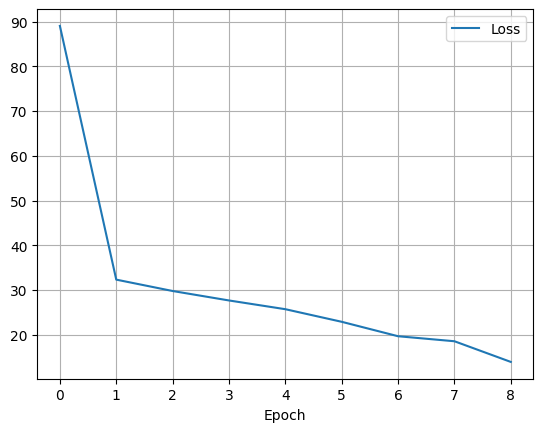

In [347]:
plt.plot(total_loss_1)
plt.xlabel('Epoch')
plt.legend(['Loss'])
plt.grid()
plt.show()

# Create Model # 2 (LSTM)

In [570]:
class Model_2(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.rnn = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=3, dropout=0.6)
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 1)
    def forward(self, X):
        out, _ = self.rnn(X)
        out = F.sigmoid(self.fc1(out[:, -1, :]))
        return F.sigmoid(self.fc2(out))
    
model_2 = Model_2(hidden_size=50)

In [571]:
model_2

Model_2(
  (rnn): LSTM(1, 50, num_layers=3, dropout=0.6)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
)

In [572]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0002)

In [573]:
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

In [574]:
total_epoch = 30
total_loss_2 = []
for epoch in range(total_epoch):
    model_2.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        outputs = model_2(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    total_loss_2.append(epoch_loss)
    print(f"Epoch[{epoch + 1}/{total_epoch}], Loss: {epoch_loss / len(train_loader)}")
    if (epoch_loss / len(train_loader)) < 0.044:
        break

C:\Users\Denis\AppData\Local\Temp\ipykernel_10020\2333624673.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


Epoch[1/30], Loss: 0.06341345098146514
Epoch[2/30], Loss: 0.06330298684707314
Epoch[3/30], Loss: 0.06328781343999672
Epoch[4/30], Loss: 0.06329585406551691
Epoch[5/30], Loss: 0.06334124141202836
Epoch[6/30], Loss: 0.0631413674233733
Epoch[7/30], Loss: 0.06273438169973324
Epoch[8/30], Loss: 0.06200747506966739
Epoch[9/30], Loss: 0.05997498381121487
Epoch[10/30], Loss: 0.047864115204995596
Epoch[11/30], Loss: 0.030458313847633985


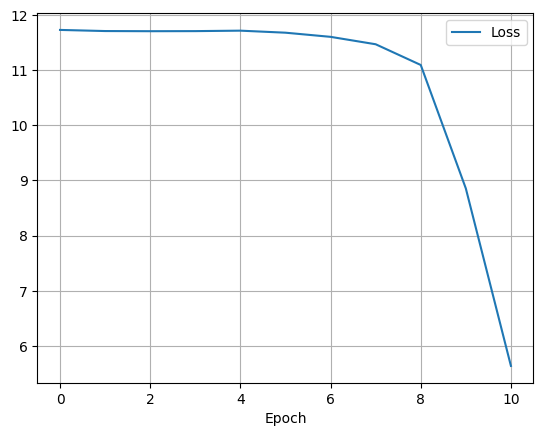

In [575]:
plt.plot(total_loss_2)
plt.xlabel('Epoch')
plt.legend(['Loss'])
plt.grid()
plt.show()

# Model # 3 (GRU_NN)

In [704]:
class Model_3(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.rnn1 = nn.GRU(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.drop = nn.Dropout(0.3)
        self.rnn2 = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.rnn3 = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.rnn4 = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.rnn1(x)
        out = self.drop(out)
        out, _ = self.rnn2(out)
        out, _ = self.rnn3(out)
        # out, _ = self.rnn4(out)
        out = self.fc1(out[:, -1, :])
        return F.sigmoid(out)

model_3 = Model_3(hidden_size=25)    

In [705]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)

In [706]:
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

In [707]:
total_epoch = 20
total_loss_3 = []
for epoch in range(total_epoch):
    model_3.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        outputs = model_3(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    total_loss_3.append(epoch_loss)
    print(f"Epoch[{epoch + 1}/{total_epoch}], Loss: {epoch_loss / len(train_loader)}")

C:\Users\Denis\AppData\Local\Temp\ipykernel_10020\2333624673.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


Epoch[1/20], Loss: 0.0617901206545129
Epoch[2/20], Loss: 0.053338955190485794
Epoch[3/20], Loss: 0.023813958090692255
Epoch[4/20], Loss: 0.003925767268142285
Epoch[5/20], Loss: 0.0036111279566800993
Epoch[6/20], Loss: 0.0034179174931203895
Epoch[7/20], Loss: 0.0033704457992064056
Epoch[8/20], Loss: 0.003193042614745807
Epoch[9/20], Loss: 0.002991434946326646
Epoch[10/20], Loss: 0.002920267390357834
Epoch[11/20], Loss: 0.0030564917287060904
Epoch[12/20], Loss: 0.0028481293538100767
Epoch[13/20], Loss: 0.0028418880525104876
Epoch[14/20], Loss: 0.0027336410132733904
Epoch[15/20], Loss: 0.002607579222122031
Epoch[16/20], Loss: 0.002587257791428537
Epoch[17/20], Loss: 0.002493549461452268
Epoch[18/20], Loss: 0.0024131079211459822
Epoch[19/20], Loss: 0.002516557697113918
Epoch[20/20], Loss: 0.0023738218020495166


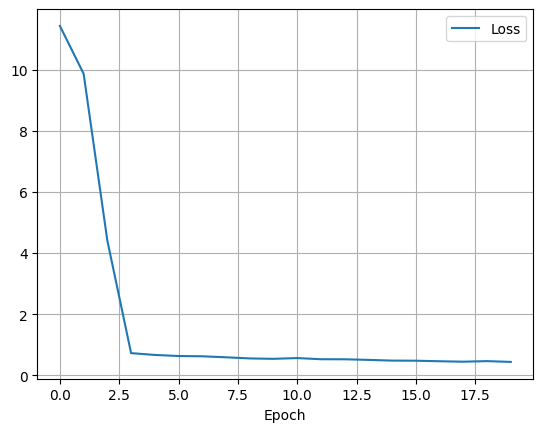

In [708]:
plt.plot(total_loss_3)
plt.xlabel('Epoch')
plt.legend(['Loss'])
plt.grid()
plt.show()

In [709]:
model_1.eval()
model_2.eval()
model_3.eval()
with torch.no_grad():
    Y_rnn = model_1(X_test)
    Y_lstm = model_2(X_test)
    Y_gru = model_3(X_test)

In [710]:
y_RNN_O = scaler.inverse_transform(Y_rnn.detach())
y_LSTM_O = scaler.inverse_transform(Y_lstm.detach())
y_GRU_O = scaler.inverse_transform(Y_gru.detach())

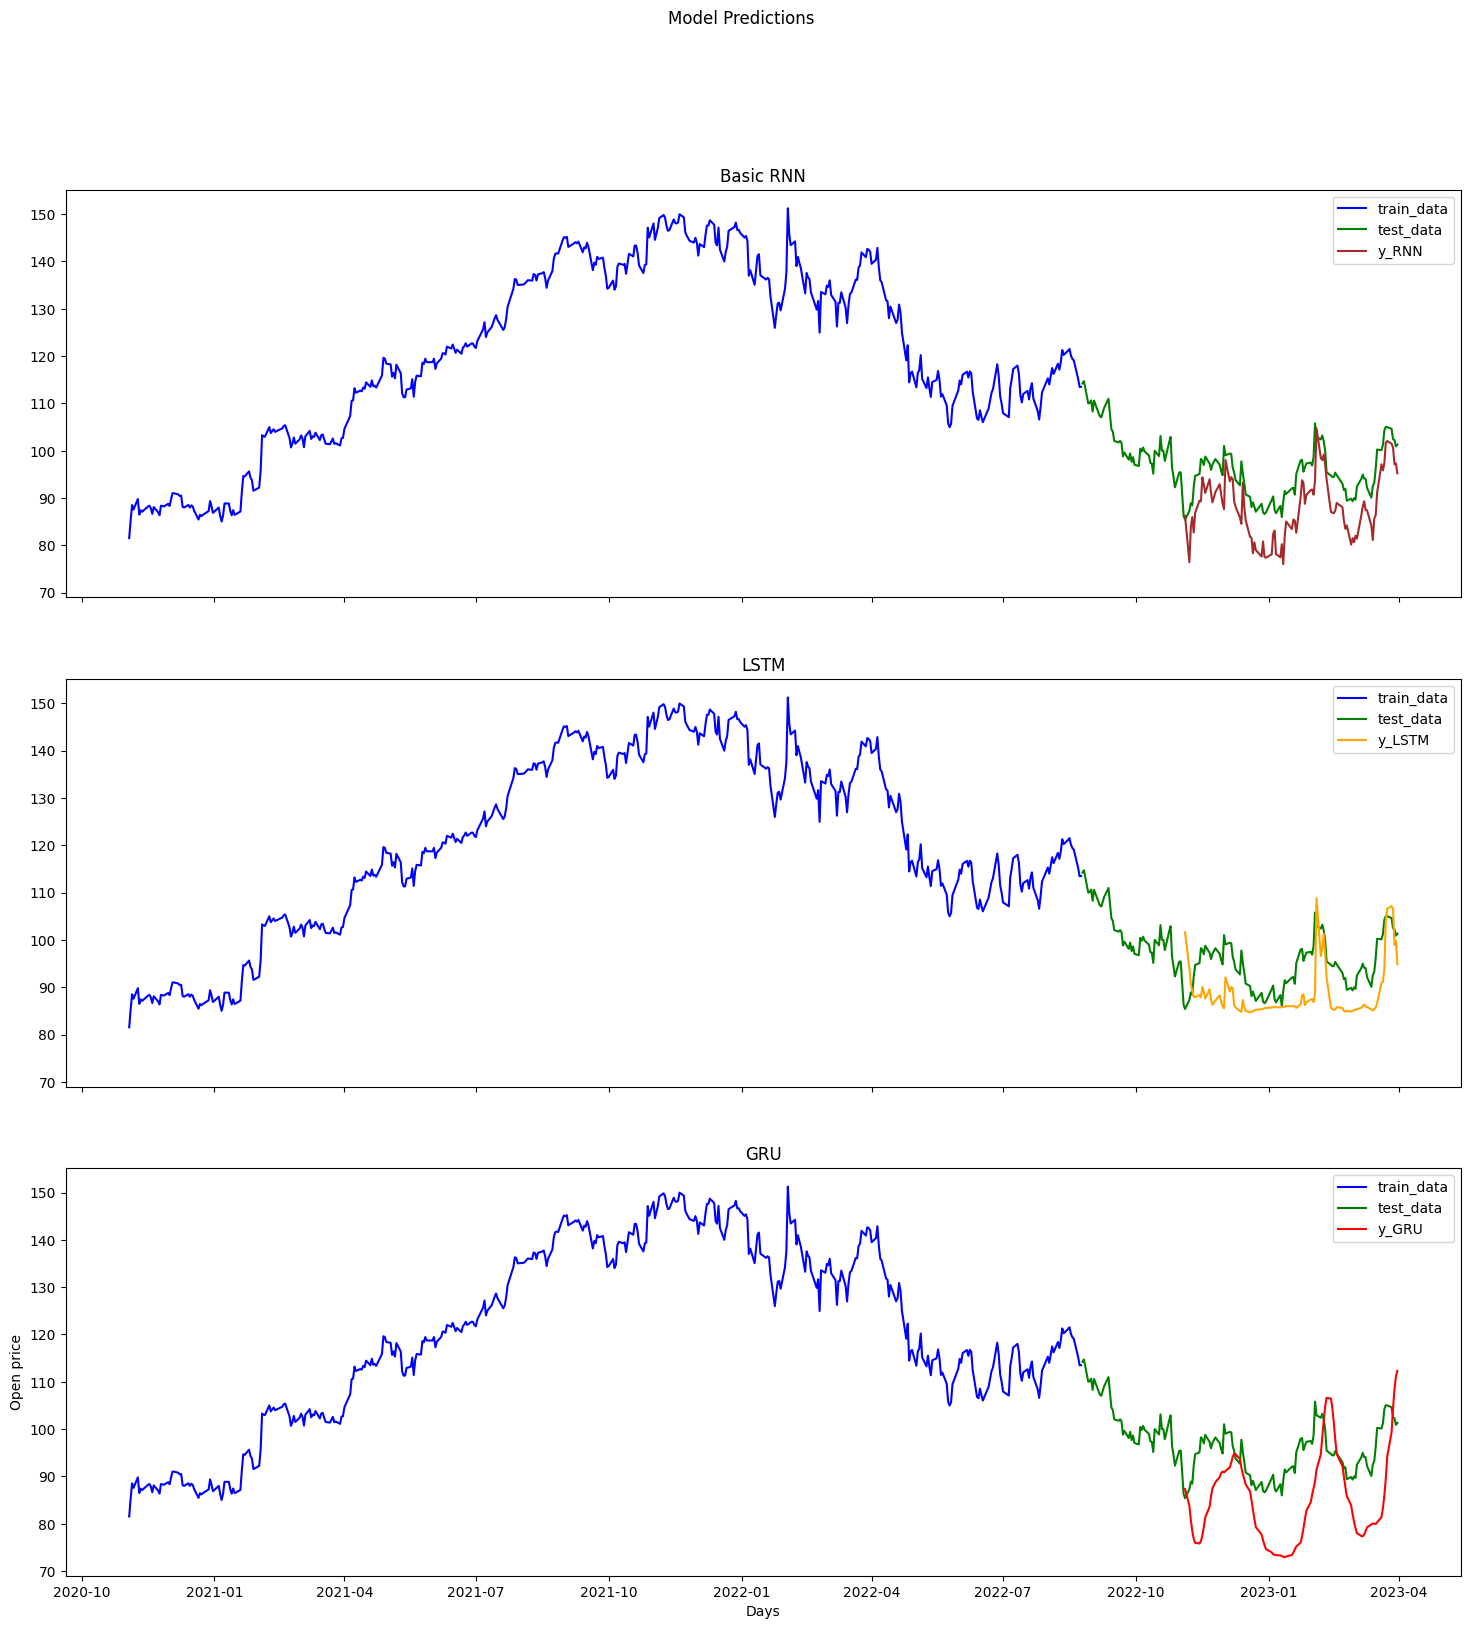

In [711]:
fig, axs = plt.subplots(3,figsize =(18,18),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
axs[0].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for LSTM predictions
axs[1].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[1].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[1].plot(test_data.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")

#Plot for GRU predictions
axs[2].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[2].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[2].plot(test_data.index[50:], y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("Open price")

plt.show()